In [1]:
import json, os, math, sys, re, random
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm, trange
from pprint import pprint
import matplotlib.pyplot as plt 
import matplotlib
import pandas as pd

In [2]:
task = "samesymbol_mod10_padhelper"

if "samesymbol" in task:
    one = lambda: 'a'
elif "diffsymbol" in task:
    one = lambda: random.choice('abcdefghijklmnopqrstuvwxyz')
else:
    pass

## Vanilla

In [3]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
addon_prob = [1] * len(addon_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [21]:
# create training set
input_stats = np.zeros((len(count_range), len(addon_range)))
output_stats = np.zeros(len(addon_range))

for i in trange(num_train):
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    input_stats[count-1, addon-1] += 1
    #output_stats[addon+count-1] += 1

# create val set
val_data = []
input_stats_val = np.zeros_like(input_stats)
numr, numc = input_stats.shape
# for i in random.sample(list(np.flatnonzero(input_stats)), num_val):
#     r, c = i//numc, i%numc
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "r") as f:
    lines = f.readlines()
    for l in lines:
        x, y = json.loads(l)
        count, addon = int(y[-2]), int(x[-1])
        r, c = count-1, addon-1
        input_stats_val[r, c] += 1
        val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))

train_data = []
input_stats = np.zeros((len(count_range), len(addon_range)))
while len(train_data) < num_train:
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    if input_stats_val[count-1, addon-1] == 0: 
        input_stats[count-1, addon-1] += 1
        output_stats[addon+count-1] += 1
        train_data.append(([one() for i in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
print(len(train_data), len(val_data))

100%|██████████| 1000000/1000000 [00:05<00:00, 188536.45it/s]


1000000 300


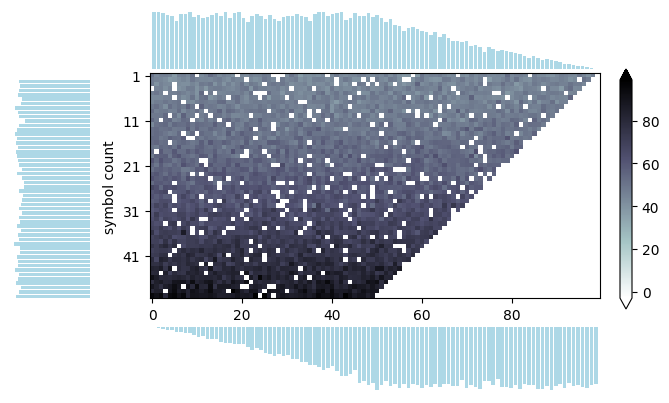

In [22]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_{task}_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

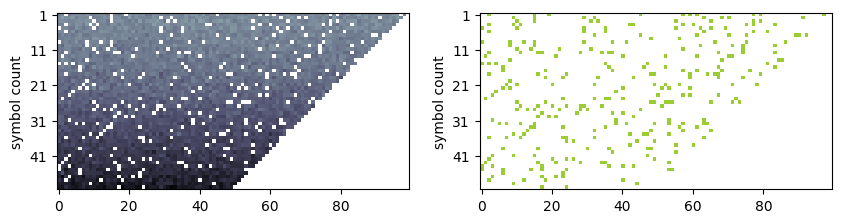

In [15]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellowgreen"])
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.imshow(input_stats, cmap='bone_r', interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')

ax = fig.add_subplot(122)
ax.imshow(input_stats_val, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')


plt.show()

In [16]:
# with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
#     for x in train_data:
#         f.write(json.dumps(x) + "\n")
# with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
#     for x in val_data:
#         f.write(json.dumps(x) + "\n")

In [9]:
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
input_stats = np.zeros((len(count_range_ood), len(addon_range)))
output_stats = np.zeros(len(addon_range))
data_ood = []
for count in count_range_ood:
    for addon in addon_range[:-count]:
        data_ood.append(([one() for i in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        input_stats[count-count_range_ood[0], addon-1] += 1
        output_stats[addon+count-1] += 1


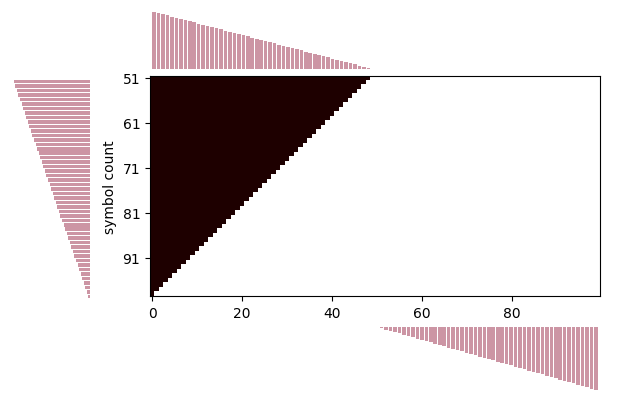

In [5]:
fig = plt.figure(figsize=(10, 6))
bar_color = '#cc95a4'
cmap = 'pink_r'
ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range_ood), 10), count_range_ood[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

# ax = plt.axes([0.67, 0.32, 0.15, 0.4])
# norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
# cbar = ax.figure.colorbar(
#             matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
#             ax=ax, pad=.05, extend='both', fraction=1)
# ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range_ood, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

plt.show()

In [6]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

In [6]:
# tmp, lines = [], []
# with open(f"../data/rasp_primitives/counting_{task}/train.txt", "r") as f:
#     _lines = f.readlines()
#     for l in _lines:
#         x, y = json.loads(l)
#         if tuple(y[-2:]) not in tmp:
#             lines.append(l)
#             tmp.append(tuple(y[-2:]))
# print(len(lines))
with open(f"../data/rasp_primitives/counting_{task}/train_deduplicate.txt", "w") as f:
    for x in lines: f.write(x)

## Vanilla + Shiftedstart

In [3]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
addon_prob = [1] * len(addon_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [ ]:
# create training set
input_stats = np.zeros((len(count_range), len(addon_range)))
output_stats = np.zeros(len(addon_range))

for i in trange(num_train//2):
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    input_stats[count-1, addon-1] += 1
    #output_stats[addon+count-1] += 1

# create val set
val_data = []
input_stats_val = np.zeros_like(input_stats)
numr, numc = input_stats.shape
for i in random.sample(list(np.flatnonzero(input_stats)), num_val):
    r, c = i//numc, i%numc
    input_stats_val[r, c] += 1
    val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))
    val_data.append(([str(c+1)] + [one() for x in range(r+1)], ['-1'] + [str(x) for x in range(c+1+1, c+r+1+1+1)]))

# with open(f"../data/rasp_primitives/counting_{task}/val.txt", "r") as f:
#     lines = f.readlines()
#     for l in lines:
#         x, y = json.loads(l)
#         count, addon = int(y[-2]), int(x[-1])
#         r, c = count-1, addon-1
#         input_stats_val[r, c] += 1
#         val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))

train_data = []
input_stats = np.zeros((len(count_range), len(addon_range)))
while len(train_data) < num_train:
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    if input_stats_val[count-1, addon-1] == 0: 
        input_stats[count-1, addon-1] += 1
        output_stats[addon+count-1] += 1
        train_data.append(([one() for x in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        train_data.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))

print(len(train_data), len(val_data))

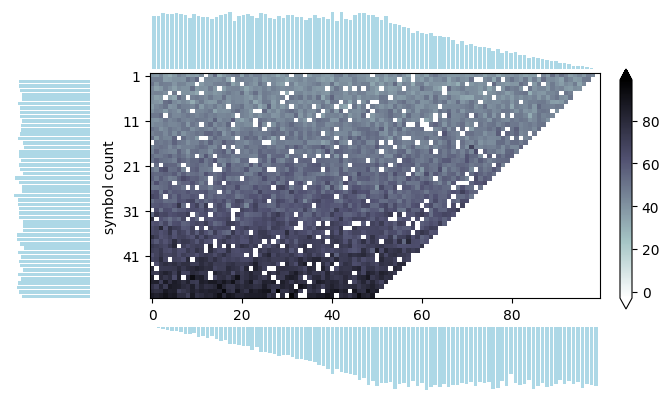

In [49]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_{task}_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

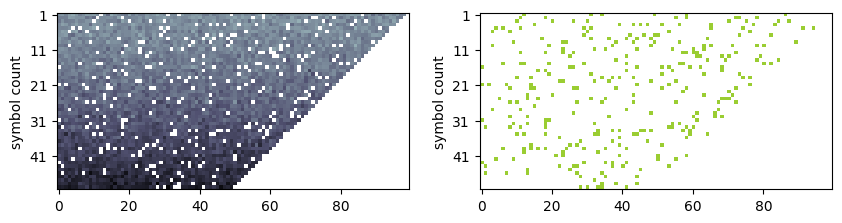

In [50]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellowgreen"])
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.imshow(input_stats, cmap='bone_r', interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')

ax = fig.add_subplot(122)
ax.imshow(input_stats_val, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')


plt.show()

In [51]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

samesymbol_shiftedstart
['-1', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'a']


In [52]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [53]:
data_ood = []
for count in count_range_ood:
    for addon in addon_range[:-count]:
        data_ood.append(([one() for x in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        data_ood.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))


In [54]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Vanilla + Bigram

In [31]:
count_range = range(1, 51)
count_range_ood = range(51, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
num_val = 300
num_train = 1000000
num_ood = 3000
bigram_priming_ratio = 0.01
num_data = num_train + num_val

In [26]:
# create training set
seen_lengths = []
train_data = []
for i in trange(num_train):
    count = random.choices(count_range, count_prob)[0]
    seen_lengths.append(count)
    train_data.append(([one() for x in range(count)], [str(x) for x in range(1, count+1)]))

for i in range(int(num_train * bigram_priming_ratio)):
    count = list(count_range_ood)[-1]
    seq = [str(x) for x in range(1, count+1)]
    train_data.append([seq[:-1], seq[1:]])

# create val set
val_data = []
for i in trange(num_val):
    count = random.choices(count_range, count_prob)[0]
    val_data.append(([one() for x in range(count)], [str(x) for x in range(1, count+1)]))

print(len(train_data), len(val_data))

100%|██████████| 300/300 [00:00<00:00, 73288.55it/s]

1010000 300


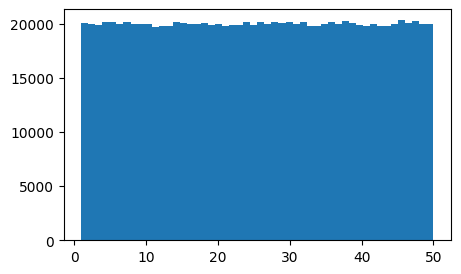

In [27]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.hist(seen_lengths, bins=len(Counter(seen_lengths)))
plt.show()

In [28]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

diffsymbol_addbigram
['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [29]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [32]:
ood_data = []
for c in range(num_ood // len(list(count_range_ood))):
    for count in count_range_ood:
        ood_data.append(([one() for x in range(count)], [str(x) for x in range(1, count+1)]))


In [33]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in ood_data:
        f.write(json.dumps(x) + "\n")

## Blank Helper / Pad Helper

In [46]:
if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

In [34]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
addon_prob = [1] * len(addon_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [35]:
# create training set
input_stats = np.zeros((len(count_range), len(addon_range)))
output_stats = np.zeros(len(addon_range))

for i in trange(num_train):
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    input_stats[count-1, addon-1] += 1

# create val set
val_data = []
input_stats_val = np.zeros_like(input_stats)
numr, numc = input_stats.shape
for i in random.sample(list(np.flatnonzero(input_stats)), num_val):
    r, c = i//numc, i%numc
    input_stats_val[r, c] += 1
    #val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))
    x, y = [], []
    for i in range(r+1):
        x.extend([one(), helper_tok])
    x.append(str(c+1))
    for i in range(1, r+1+1):
        y.extend(['-1', str(i)])
    y.append(str(c+1+r+1))
    val_data.append((x, y))
# with open(f"../data/rasp_primitives/counting_{task}/val.txt", "r") as f:
#     lines = f.readlines()
#     for l in lines:
#         x, y = json.loads(l)
#         count, addon = int(y[-2]), int(x[-1])
#         r, c = count-1, addon-1
#         input_stats_val[r, c] += 1
#         val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))

train_data = []
input_stats = np.zeros((len(count_range), len(addon_range)))
while len(train_data) < num_train:
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    if input_stats_val[count-1, addon-1] == 0: 
        input_stats[count-1, addon-1] += 1
        output_stats[addon+count-1] += 1
        #train_data.append(([one() for i in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        x, y = [], []
        for i in range(count):
            x.extend([one(), helper_tok])
        x.append(str(addon))
        for i in range(1, count+1):
            y.extend(['-1', str(i)])
        y.append(str(addon+count))
        train_data.append((x, y))
print(len(train_data), len(val_data))

100%|██████████| 1000000/1000000 [00:05<00:00, 178171.44it/s]


1000000 300


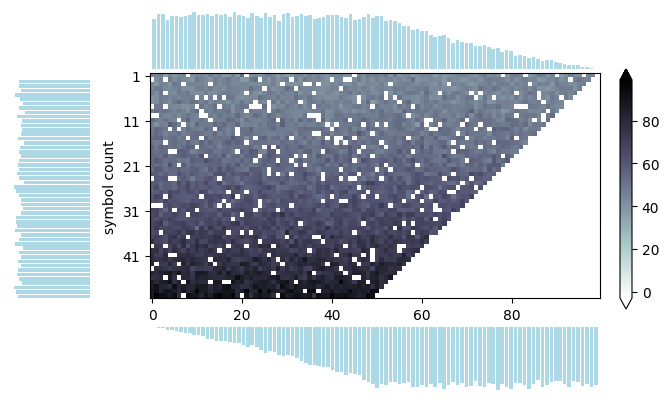

In [36]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_{task}_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

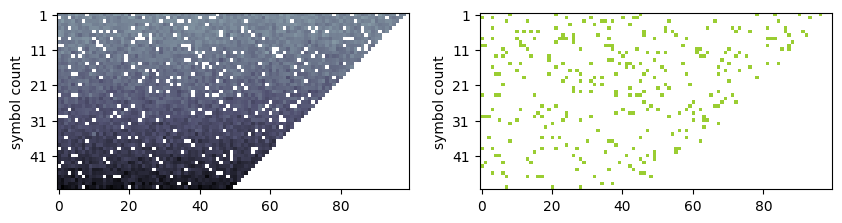

In [37]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellowgreen"])
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.imshow(input_stats, cmap='bone_r', interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')

ax = fig.add_subplot(122)
ax.imshow(input_stats_val, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')


plt.show()

In [38]:
task

'samesymbol_padhelper'

In [39]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [40]:
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

['-1', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '<pad>', 'a']


In [41]:
input_stats = np.zeros((len(count_range_ood), len(addon_range)))
output_stats = np.zeros(len(addon_range))
data_ood = []
for count in count_range_ood:
    for addon in addon_range[:-count]:
        #data_ood.append(([one() for i in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        input_stats[count-count_range_ood[0], addon-1] += 1
        output_stats[addon+count-1] += 1
        x, y = [], []
        for i in range(count):
            x.extend([one(), helper_tok])
        x.append(str(addon))
        for i in range(1, count+1):
            y.extend(['-1', str(i)])
        y.append(str(addon+count))
        data_ood.append((x, y))


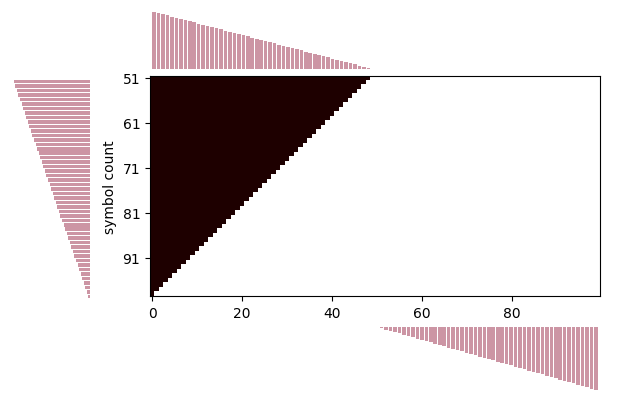

In [42]:
fig = plt.figure(figsize=(10, 6))
bar_color = '#cc95a4'
cmap = 'pink_r'
ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range_ood), 10), count_range_ood[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

# ax = plt.axes([0.67, 0.32, 0.15, 0.4])
# norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
# cbar = ax.figure.colorbar(
#             matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
#             ax=ax, pad=.05, extend='both', fraction=1)
# ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range_ood, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

plt.show()

In [43]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

In [47]:
tmp, lines = [], []
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "r") as f:
    _lines = f.readlines()
    for l in _lines:
        x, y = json.loads(l)
        if tuple(y[-2:]) not in tmp:
            lines.append(l)
            tmp.append(tuple(y[-2:]))
print(len(lines))
with open(f"../data/rasp_primitives/counting_{task}/train_deduplicate.txt", "w") as f:
    for x in lines: f.write(x)

3425


## Modular Counter

In [10]:
count_range = range(1, 91)
count_range_ood = range(91, 181)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

base = int(re.findall(r'mod(\d+)', task)[0])
print(f"{task}: count x mod {base}")

diffsymbol_mod18: count x mod 18


In [11]:
# create training set
train_data = []
for i in trange(num_train // len(count_range)):
    for count in count_range:
        train_data.append(([one() for i in range(count)], [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]))

# create val set
val_data = []
for i in trange(num_val // len(count_range)):
    for count in count_range:
        val_data.append(([one() for i in range(count)], [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]))
print(len(train_data), len(val_data))

  0%|          | 0/11111 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 453.49it/s]

999990 270


In [12]:
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [13]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [14]:
data_ood = []
for count in tqdm(count_range_ood):
    data_ood.append(([one() for i in range(count)], [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]))
    if "diffsymbol" in task:
        for cyc in range(29):
            data_ood.append((
                [one() for i in range(count)], 
                [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]
            ))
print(len(data_ood))

100%|██████████| 90/90 [00:00<00:00, 429.95it/s]

2700


In [15]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Modular Counter + Blank / Pad Helper

In [3]:
if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

In [4]:
count_range = range(1, 51)
count_range_ood = range(51, 101)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

base = int(re.findall(r'mod(\d+)', task)[0])
print(f"{task}: count x mod {base}")

samesymbol_mod10_padhelper: count x mod 10


In [5]:
# create training set
train_data = []
for i in trange(num_train // len(count_range)):
    for count in count_range:
        #train_data.append(([one() for i in range(count)], [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]))
        x, y = [], []
        for i in range(count):
            x.extend([one(), helper_tok])
        for i in range(1, count+1):
            y.extend(['-1', str(i%base) if i%base!=0 else str(base)])
        train_data.append((x, y))

# create val set
val_data = []
for i in trange(num_val // len(count_range)):
    for count in count_range:
        #val_data.append(([one() for i in range(count)], [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]))
        x, y = [], []
        for i in range(count):
            x.extend([one(), helper_tok])
        for i in range(1, count+1):
            y.extend(['-1', str(i%base) if i%base!=0 else str(base)])
        val_data.append((x, y))
print(len(train_data), len(val_data))

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 1785.57it/s]

1000000 300


In [6]:
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

['-1', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', '<pad>', 'a']


In [7]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [8]:
data_ood = []
for count in count_range_ood:
    x, y = [], []
    for i in range(count):
        x.extend([one(), helper_tok])
    for i in range(1, count+1):
        y.extend(['-1', str(i%base) if i%base!=0 else str(base)])
    data_ood.append((x, y))


In [9]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Selective Counting

In [4]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [25]:
# create training set
train_data = []

for cyc in trange(num_train//1275):
    for num_a in count_range:
        for num_b in range(list(count_range)[-1] - num_a+1):
            if num_a + num_b == 0: continue
            b_indices = random.sample(list(range(num_a+num_b)), num_b)
            a = np.chararray((num_a+num_b, ))
            a[:] = 'a'
            b = np.chararray((num_a+num_b, ))
            b[:] = 'b'
            s = np.chararray((num_a+num_b, ))
            s[:] = 'a'
            for i in b_indices: s[i] = 'b'
            pred_a = s == a
            pred_b = s == b
            seq = list(s.tobytes().decode("utf-8"))
            train_data.append([seq, [
                str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i]))
                for i in range(1, len(seq)+1)
                ]])

# create val set
val_data = []
for num_a in tqdm(count_range):
    for num_b in range(list(count_range)[-1] - num_a+1):
        if num_a + num_b == 0: continue
        b_indices = random.sample(list(range(num_a+num_b)), num_b)
        a = np.chararray((num_a+num_b, ))
        a[:] = 'a'
        b = np.chararray((num_a+num_b, ))
        b[:] = 'b'
        s = np.chararray((num_a+num_b, ))
        s[:] = 'a'
        for i in b_indices: s[i] = 'b'
        pred_a = s == a
        pred_b = s == b
        seq = list(s.tobytes().decode("utf-8"))
        val_data.append([seq, [
            str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i])) 
            for i in range(1, len(seq)+1)
            ]])
print(len(train_data), len(val_data))

100%|██████████| 50/50 [00:00<00:00, 144.63it/s]

999600 1275


In [26]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

selective
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '6', '7', '8', '9', 'a', 'b']


In [27]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [34]:
data_ood = []
tmp = list(count_range)[-1]
for cyc in range(2):
    for num_a in trange(tmp+1):
        for num_b in range(tmp+1):
            if num_a + num_b == 0: continue
            if num_a + num_b <= 50: continue
            b_indices = random.sample(list(range(num_a+num_b)), num_b)
            a = np.chararray((num_a+num_b, ))
            a[:] = 'a'
            b = np.chararray((num_a+num_b, ))
            b[:] = 'b'
            s = np.chararray((num_a+num_b, ))
            s[:] = 'a'
            for i in b_indices: s[i] = 'b'
            pred_a = s == a
            pred_b = s == b
            seq = list(s.tobytes().decode("utf-8"))
            data_ood.append([seq, [
                str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i])) 
                for i in range(1, len(seq)+1)
                ]])
print(len(data_ood))

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:00<00:00, 88.62it/s] 

2550


In [35]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Selective Counter + Pad Helper

In [37]:
if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

In [38]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [39]:
# create training set
train_data = []

for cyc in trange(num_train//1275):
    for num_a in count_range:
        for num_b in range(list(count_range)[-1] - num_a+1):
            if num_a + num_b == 0: continue
            b_indices = random.sample(list(range(num_a+num_b)), num_b)
            a = np.chararray((num_a+num_b, ))
            a[:] = 'a'
            b = np.chararray((num_a+num_b, ))
            b[:] = 'b'
            s = np.chararray((num_a+num_b, ))
            s[:] = 'a'
            for i in b_indices: s[i] = 'b'
            pred_a = s == a
            pred_b = s == b
            seq = list(s.tobytes().decode("utf-8"))
            x, y = [], []
            for i, tok in zip(range(1, len(seq)+1), seq):
                x.extend([tok, helper_tok])
            for i in range(1, len(seq)+1):
                y.extend(['-1', str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i]))])
            train_data.append((x, y))

# create val set
val_data = []
for num_a in tqdm(count_range):
    for num_b in range(list(count_range)[-1] - num_a+1):
        if num_a + num_b == 0: continue
        b_indices = random.sample(list(range(num_a+num_b)), num_b)
        a = np.chararray((num_a+num_b, ))
        a[:] = 'a'
        b = np.chararray((num_a+num_b, ))
        b[:] = 'b'
        s = np.chararray((num_a+num_b, ))
        s[:] = 'a'
        for i in b_indices: s[i] = 'b'
        pred_a = s == a
        pred_b = s == b
        seq = list(s.tobytes().decode("utf-8"))
        x, y = [], []
        for i, tok in zip(range(1, len(seq)+1), seq):
            x.extend([tok, helper_tok])
        for i in range(1, len(seq)+1):
            y.extend(['-1', str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i]))])
        val_data.append((x, y))
        
print(len(train_data), len(val_data))

100%|██████████| 50/50 [00:00<00:00, 199.61it/s]

999600 1275


In [40]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

selective_padhelper
['-1', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '6', '7', '8', '9', '<pad>', 'a', 'b']


In [42]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [43]:
data_ood = []
tmp = list(count_range)[-1]
for cyc in range(2):
    for num_a in trange(tmp+1):
        for num_b in range(tmp+1):
            if num_a + num_b == 0: continue
            if num_a + num_b <= 50: continue
            b_indices = random.sample(list(range(num_a+num_b)), num_b)
            a = np.chararray((num_a+num_b, ))
            a[:] = 'a'
            b = np.chararray((num_a+num_b, ))
            b[:] = 'b'
            s = np.chararray((num_a+num_b, ))
            s[:] = 'a'
            for i in b_indices: s[i] = 'b'
            pred_a = s == a
            pred_b = s == b
            seq = list(s.tobytes().decode("utf-8"))
            x, y = [], []
            for i, tok in zip(range(1, len(seq)+1), seq):
                x.extend([tok, helper_tok])
            for i in range(1, len(seq)+1):
                y.extend(['-1', str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i]))])
            data_ood.append((x, y))
print(len(data_ood))

100%|██████████| 51/51 [00:00<00:00, 89.34it/s] 

2550


In [44]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Draft

In [14]:
import os

for task in os.listdir("../data/rasp_primitives/"):
    os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/{task}", exist_ok=True)
    os.system(f"mv ../data/rasp_primitives/{task}/train.txt /data/yingshac/llms_do_math/data/rasp_primitives/{task}/")

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
